<a href="https://colab.research.google.com/github/db-gb/Neural_Machine_Translator/blob/master/NMT_Using_FastText_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import tqdm
import numpy as np
import pandas as pd
import gensim
import nltk
import re
import matplotlib.pyplot as plt
from collections import Counter
from gensim.models import FastText
from gensim.models import KeyedVectors
from keras.layers import Input, CuDNNLSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

from collections import defaultdict

# Neural Machine Translation Using FastText Word Embeddings
One of the most exciting features of neural networks is their ability to train computers to generate novel text. This holds a lot of promise in the field of natural language translation. Human language is very complex, and every language has its nuances and exceptions. This makes the task all the more difficult. 

In this article, I will walk through the steps of creating a Neural Machine Translator that translates from English to Spanish using pre-trained FastText word embeddings. 

We will use the English-Spanish sentence pairs available on http://www.manythings.org/anki/. Click [here](http://www.manythings.org/anki/spa-eng.zip) to download. 

In [0]:
# http://www.manythings.org/anki/spa-eng.zip
data_path = "/content/drive/My Drive/Spanish_Bible_Translation/spa.txt"

# Read the file
with open(data_path, 'r', encoding='utf-8') as p:
  lines = p.read().split('\n')

  print(len(lines))

122937


In [0]:
# There are over 120000 samples. To conserve memory, we will randomly sample 50,000 out of the first 80,000
num_samples = 50000
lines_to_consider = 80000

## Text Preprocessing
Now that we've read the lines from the file, we will perform some preprocessing steps. In this case, we will convert the sentences to all lower-case and remove and special characters. I've borrowed the following code from Dipanjan Sarkar's excellent [tutorial](https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/feature%20engineering%20text%20data/Feature%20Engineering%20Text%20Data%20-%20Traditional%20Strategies.ipynb) [1]. This function will perform the preprocessing steps we want. 

In [0]:
wpt = nltk.WordPunctTokenizer()

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub("[^\w\s]", "", doc);

    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)

    # re-create document from filtered tokens
    doc = ' '.join(tokens)
    return doc

Looking through the training data, we see that the sentences start out short and tend to get longer as we proceed through the file. To remedy this, we randomize the selection of sentences that we will train our model on. This will make sure our model is validated on a similar set of sentences to the training data. Otherwise, our model's validation set will have longer sentences than the training set. This will cause our model to perform more poorly against the validation data.

Using the function we created above, we normalize each of the sentences. Also, we add start and end tokens to our Spanish sentences. I will explain the need for these tokens a little later on when I describe the encoder-decoder model. 

In [0]:
import random

# Store each of the English and Spanish language statements in two arrays
eng_sents = []
span_sents = []

# Select a random set of indices. 
random_idx = random.sample(range(0, lines_to_consider-1), num_samples)

# Grab the randomized lines
lines_randomized = []
for idx in random_idx:
  lines_randomized.append(lines[idx])

# Split the lines into English and Spanish equivalents
for line in lines_randomized:
  eng, span, _ = line.split('\t')

  # Use normalize function to normalize sentences before appending to arrays
  eng_sents.append(normalize_document(eng))
  # Add start and stop tokens to target language phrases 
  #span_sents.append('START_ ' + normalize_document(span) + ' _END')
  span_sents.append(normalize_document(span))

# Data Exploration
Now that we've imported our sample sentences and normalized them, we will explore the sentences and the words to have a better understanding of what we're dealing with. First we will explore the English sentences, then the Spanish.


## English Text
It's a good idea to see how long the longest sentence is, and the average length of all the sentences. This will help us establish how long we want our input sequences to be.

In [0]:
# list of all sentence lengths
eng_sent_lens = [len(sent.split()) for sent in eng_sents]

print("Average English sentence length: ", np.mean(eng_sent_lens))
print("Longest English sentence length: ", np.max(eng_sent_lens))

Average English sentence length:  4.91958
Longest English sentence length:  10


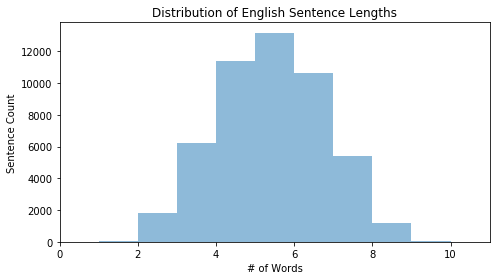

In [0]:
fig, ax1 = plt.subplots(figsize=(7, 4))

# fixed bin size
bins = np.arange(0, max(eng_sent_lens)+1, 1) # fixed bin size

color = 'tab:blue'
ax1.set_xlabel('# of Words')
ax1.set_ylabel('Sentence Count')
ax1.set_xlim([min(eng_sent_lens)-1, max(eng_sent_lens)+1])
ax1.hist(eng_sent_lens, bins=bins, alpha=0.5, color=color)
plt.title("Distribution of English Sentence Lengths")


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Plotting the distribution of sentence lengths shows a very nice bell curve with an average length of about 5 words. We notice that more than 99% of sentences have a length of 8 or less. For now, we will set the input sequence length to 8.
This will help us when we build our input matrix for our neural network. Shortening the input sentence length will make our input matrix smaller and less-memory intensive.

In [0]:
# Define input sequence length. This is how many words our input matrix will make space for later on. 
input_seq_len = 8

In [0]:
unique, counts = np.unique(eng_sent_lens, return_counts=True)
dict(zip(unique, counts))

{1: 43,
 2: 1824,
 3: 6207,
 4: 11391,
 5: 13176,
 6: 10645,
 7: 5435,
 8: 1205,
 9: 72,
 10: 2}

Next, we create a dictionary of all English words that appear in the corpus, as well as the count of each word.

In [0]:
# Define a dictionary to store all English words
eng_dict = dict()

# Loop through each sentence in corpus
for sent in eng_sents:
  # Split each sentence into words and loop through each word
  for wrd in sent.split(" "):
    # If the word is already in dictionary, increment its count
    if wrd in eng_dict:
      eng_dict[wrd] += 1
    # Otherwise, instantiate its count to 1
    else:
      eng_dict[wrd] = 1

print("Number of unique English words: ", len(eng_dict))

Number of unique English words:  7983


There appear to be about 8000 unique English words used throughout the entire corpus. If we create a matrix with a column for each unique word, we will end up with quite a large matrix. Not every word is created equal, and if we could somehow exclude less important words, we might save ourselves a lot of memory.

Let's group the words in terms of frequency and see what we find.

In [0]:
# Create a counter object that will count word frequencies
cnt = Counter()

# Create a list of the counts of each word
for wrd_cnt in list(eng_dict.values()):
  # Add each word's frequency to the counter
  cnt[wrd_cnt] += 1

# Print most common word frequencies
cnt.most_common(10)

[(1, 2899),
 (2, 1212),
 (3, 669),
 (4, 437),
 (5, 327),
 (6, 220),
 (7, 196),
 (8, 135),
 (9, 118),
 (10, 97)]

The above shows us that 2913 words appear only once, 1157 appeared twice, and so on. 

We see that over a third of the words appear only once, and about half appear two times or fewer. If we could eliminate these words that appear in only one or two sentences out of the whole corpus, we can make our input matrix quite a bit smaller in terms of column count. 

In [0]:
# Create a list of only those words that appear more than twice in entire corpus
eng_wrds = [wrd for wrd in eng_dict if eng_dict[wrd] > 2]

print("Our model will train on {} English words.".format(len(eng_wrds)))

Our model will train on 3872 English words.


In [0]:
eng_wrds.append('_UNK_')

In [0]:
input_words = sorted(list(eng_wrds))
num_encoder_tokens = len(eng_wrds)
del eng_wrds

## Spanish Text
We will now perform the same analysis on the Spanish translations of the text.

In [0]:
# list of all sentence lengths
span_sent_lens = [len(sent.split()) for sent in span_sents]

print("Average Spanish sentence length: ", np.mean(span_sent_lens))
print("Longest Spanish sentence length: ", np.max(span_sent_lens))

Average Spanish sentence length:  4.71468
Longest Spanish sentence length:  15


We see that the average Spanish sentence is also about 5 words long, which is in line with the average English sentence length. However, the longest English sentence was only 10 words long, while the longest Spanish sentence is 15 words long. An interesting analysis would be to inspect the sentences whose lengths differ by more than x words and see what's behind the difference. For now, we will ignore this difference.

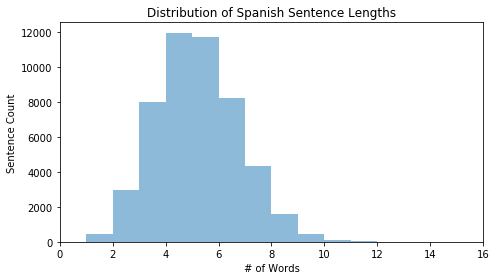

In [0]:
fig, ax1 = plt.subplots(figsize=(7, 4))

# fixed bin size
bins = np.arange(0, max(span_sent_lens)+1, 1) # fixed bin size

color = 'tab:blue'
ax1.set_xlabel('# of Words')
ax1.set_ylabel('Sentence Count')
ax1.set_xlim([min(span_sent_lens)-1, max(span_sent_lens)+1])
ax1.hist(span_sent_lens, bins=bins, alpha=0.5, color=color)
plt.title("Distribution of Spanish Sentence Lengths")


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [0]:
unique, counts = np.unique(span_sent_lens, return_counts=True)
dict(zip(unique, counts))

{1: 449,
 2: 2993,
 3: 8034,
 4: 11971,
 5: 11722,
 6: 8220,
 7: 4361,
 8: 1614,
 9: 473,
 10: 122,
 11: 30,
 12: 9,
 14: 1,
 15: 1}

We see that there is a slight positive skew (tail on the right) on the distribution of Spanish sentence lengths. However, the skew is small and only a tiny fraction of sentences have more than 9 words. This means we will be able to use a smaller matrix to contain our Spanish sentences without the risk of slicing off too many words. 

In [0]:
# Define a dictionary to store all Spanish words
span_dict = dict()

# Loop through each sentence in corpus
for sent in span_sents:
  # Split each sentence into words and loop through each word
  for wrd in sent.split(" "):
    # If the word is already in dictionary, increment its count
    if wrd in span_dict:
      span_dict[wrd] += 1
    # Otherwise, instantiate its count to 1
    else:
      span_dict[wrd] = 1

print("Number of unique Spanish words: ", len(span_dict))

Number of unique Spanish words:  14826


Whereas the sentence lengths seemed to line up rather closely with the English sentences, it seems that the number of unique words in the Spanish text is much higher than that of the English. 

This most likely has to do with differences in the morphological typology of the two languages. Spanish is a much more fusional language consisting of a wide variety of verb conjugations and moods. Each conjugation of a verb is effectively a different word according to our approach. 

English, on the other hand, is much more analytic. There are fewer conjugations and each word contains a smaller number of morphemes [2].

An example of this is in the conjugation for the verb 'to go', or 'ir' in Spanish. 

English: I go, you go, he/she goes, they go, we go - > 8 unique words

Spanish: yo voy, tu vas, el/ella va, nosotros vamos, ellos/ellas van -> 12 unique words

This difference in morphological types is one of many reasons why creating the perfect translator is so difficult. However, for our purposes, we will have to live with this difficulty and see how our translator performs regardless.

In [0]:
# Create a counter object that will count word frequencies
cnt = Counter()

# Create a list of the counts of each word
for wrd_cnt in list(span_dict.values()):
  # Add each word's frequency to the counter
  cnt[wrd_cnt] += 1

# Print most common word frequencies
cnt.most_common(10)

[(1, 6791),
 (2, 2365),
 (3, 1231),
 (4, 715),
 (5, 505),
 (6, 373),
 (7, 295),
 (8, 235),
 (9, 170),
 (10, 162)]

Again we see that about half the unique words in the Spanish corpus appear a total of 2 or fewer times. In the interest of keeping our memory footprint smaller, we will eliminate these from our words to consider. Since we will have to account for these rare words somehow, we'll create a fallback "Unknown" word that catches these. 

In [0]:
# Create a list of only those words that appear more than twice in entire corpus
span_wrds = [wrd for wrd in span_dict if span_dict[wrd] > 2]

print("Our model will train on {} Spanish words.".format(len(span_wrds)))

Our model will train on 5670 Spanish words.


### Start and Stop Tokens
Now we add start and stop tokens to the output language sentences. The start token will serve as an offset to help us train our model to predict the first word of the output sentence. The stop token will serve as a flag for our model to finish translating once it predicts a stop token.

In [0]:
# Add start and stop tokens to target language phrases
span_sents = ['START_ ' + sent + ' _END' for sent in span_sents]

# Append Start and Stop tokens to dictionary as well as UNK to handle unknown words
span_wrds.append('START_')
span_wrds.append('_END')
span_wrds.append('_UNK_')
print(len(span_wrds))

5673


In [0]:
# Having an output sequence length of 9 would cover about 98% of our sentences. Add 1 to that to account for the STOP token. 
output_seq_len = 10

In [0]:
output_words = sorted(span_wrds)
num_decoder_tokens = len(span_wrds)
del span_wrds

## Big Picture
Up to now, we have successfully analyzed the training text for our neural machine translator. We have determined the sentence lengths of the English and Spanish sentences. We've added the Start and Stop tokens to the Spanish text. We've created dictionaries of all words in our corpora, and we've filtered to remove words that appear only 1-2 times. 

Next, we will import word embeddings which will allow us to convert words in our dictionary to numerical vectors that our neural machine translator will be able to understand. 

Ultimately, our aim is to create a multidimensional matrix that captures all of our text in numerical form for both languages. Our matrix must contain values for every word of every sentence. We know how many sentences we're training on, and we've determined a sequence length for both English and Spanish that will hold almost all sentences in the text. Now we need a way to convert the individual words into numbers. For this, we will use FastText word embeddings. 


# Import FastText Word Embeddings

Word embeddings are an extremely useful tool in NLP. They work off the premise that you can learn a lot about the meaning of words based on the contexts they appear in. Word embeddings are an attempt to capture these relationships between words in a matrix of real numbers. Words that appear in similar contexts will result in vectors that are closer to one another. They allow for enormous dimensionality reduction compared to traditional approaches such as Bag-of-Words, with the added benefit in capturing similarities in meaning. You can learn more about word embeddings [here](https://en.wikipedia.org/wiki/Word_embedding) [4]. 

There are many approaches to creating word embeddings. For this exercise, we will use the pretrained embeddings provided by Facebook's Fasttext. While we could train our own embeddings using only the training data, using pretrained embeddings should provide an advantage because Facebook has access to millions of texts. For this reason, FastText embeddings bring in much more context knowledge for the individual words. Our dataset provides nowhere near enough training material.

Another advantage of using FastText is that it provides word embeddings for many different languages. You can find them [here](https://fasttext.cc/docs/en/pretrained-vectors.html) [3]. 

We begin by importing the English FastText vectors.

In [0]:
ft_eng = KeyedVectors.load("/content/drive/My Drive/Spanish_Bible_Translation/fasttext_gensim_en.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


The FastTextKeyedVectors objects contains 300-dimensional vectors for every word that FastText was trained on. We will convert the words in our training data into these vectors. Each sentence will then be represented by the FastText vector for each word in order.

### Handling Out-of-Vocabulary (OOV) Words
In any large corpus, you are bound to encounter words that the popular pretrained word embeddings like FastText and Word2Vec do not account for. You need a robust way to handle these. 

One approach is to create random word embeddings for OOV words. However, this introduces the risk of the OOV word embeddings being complete outliers in the word embedding vector space. A simple remedy for this is to take the average of all the other word embeddings in the corpus. This will make sure your OOV word embeddings are not complete outliers that skew our model too heavily.

First, let's see how many words in our corpus are unaccounted for in the FastText embeddings.

In [0]:
input_oov_words = []

for i, wrd in enumerate(input_words):
  if wrd not in ft_eng.vocab:
    input_oov_words.append(wrd)

print("Number of English OOV words: ", len(input_oov_words))

Number of English OOV words:  7


We see that the OOV words make up a very small portion of the total vocabulary, which suggests that we are okay to try the method outlined above. 

In [0]:
# Create a dictionary that has every word from our corpus, as well as its corresponding word embedding.
# This code inspired by sbongo on Kaggle [4].
input_embeddings_index = dict()

# Loop through all English words we have selected to train on above
for i, word in enumerate(input_words):
  try:
    embedding_vector = ft_eng.get_vector(word)
    # if the word is not found in the FastText embedding, a KeyError is generated
  except KeyError:
    # in case of error, set word's value to None
    embedding_vector = None
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    input_embeddings_index[i] = embedding_vector

In [0]:
# Taking a look at our word embeddings matrix shows a 300-column matrix where each row represents a word from our corpus, and its 300 dimension representation. 
embeds_df = pd.DataFrame.from_dict(input_embeddings_index)

embeds_df.transpose().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.024656,0.314972,-0.005146,-0.246556,0.086365,-0.045476,-0.295176,0.219644,-0.152214,0.018355,-0.192909,0.010552,0.196710,-0.013367,-0.159703,-0.378519,0.193004,-0.051495,-0.119618,0.011138,0.075937,0.117314,0.090979,-0.158478,0.403316,-0.183122,0.069790,0.168916,-0.062730,0.206916,0.015576,0.017910,0.076775,-0.107903,0.013860,0.260337,-0.021298,0.126669,0.130145,-0.175388,...,0.110815,0.128429,-0.474402,0.083203,-0.070008,-0.047603,0.083251,0.060340,0.136434,0.741646,0.143054,0.044781,0.475872,0.257370,-0.068337,0.096999,-0.103513,0.500242,0.394369,0.090317,0.261285,-0.049771,0.328350,-0.033421,0.107528,0.024151,-0.098062,-0.141807,0.148600,-0.029346,-0.509539,0.082166,-0.471768,-0.396551,0.097199,0.054422,0.146011,1.785282,-0.124270,-0.138877
1,-0.077940,-0.013375,-0.040519,0.025240,0.007050,-0.056055,-0.245428,0.004008,-0.202918,-0.016053,0.177788,0.130013,0.020246,-0.044872,0.142649,-0.046941,0.032662,-0.070071,0.025097,0.048525,-0.138796,-0.090938,0.067453,-0.309068,0.018225,-0.091944,0.005626,0.122892,0.019711,0.071462,0.177539,0.027793,0.013847,-0.043586,-0.018087,0.100908,-0.044851,-0.012540,0.072664,-0.069090,...,0.203686,0.086665,-0.056651,0.097758,-0.166555,0.029125,0.077378,0.008948,-0.052109,0.079798,0.195495,-0.001645,0.015319,0.010317,0.111552,-0.177327,0.013760,0.039803,0.059674,0.097895,0.104846,0.102773,0.103458,-0.073722,0.082919,0.047832,-0.037986,-0.116443,0.124333,-0.038435,-0.097613,0.061389,-0.036170,0.024187,0.015093,0.007598,0.191991,0.720688,-0.128143,0.040287
2,0.044351,-0.048641,0.055769,0.026978,-0.042711,0.043635,-0.205185,0.064957,-0.046559,0.037053,-0.001812,0.090937,0.081294,0.018214,-0.007236,0.000836,0.039685,-0.133132,0.009637,0.030598,-0.079288,-0.046162,-0.012947,-0.204195,-0.055754,-0.019038,-0.010965,-0.010909,0.065727,0.049580,0.236541,0.061714,-0.036478,-0.071829,-0.012632,0.071946,-0.114191,0.064537,0.004451,-0.022068,...,0.013155,-0.001146,-0.067044,0.080927,-0.224239,0.056297,0.080608,0.017235,0.082128,0.065650,0.020189,0.063570,-0.012870,-0.118848,0.037302,-0.063459,0.042612,0.011375,-0.023481,0.032677,0.086424,0.014566,0.068131,0.007103,-0.079223,0.041792,0.029811,-0.079439,0.112950,-0.094655,-0.062548,0.038971,0.114171,0.034482,0.020712,0.031935,0.033440,0.421183,-0.158060,-0.050049
3,0.071127,-0.052138,0.033053,0.003264,-0.072915,0.034676,-0.189997,0.058901,-0.035795,0.119473,0.004229,0.027618,0.086226,-0.000558,0.022017,-0.004881,0.039690,-0.138336,0.100832,0.006392,0.068019,-0.041607,0.019578,-0.130116,0.003432,-0.072940,-0.096088,0.079649,0.094946,0.113494,0.166653,0.052580,-0.023510,-0.024061,0.032528,-0.020452,-0.086625,0.048702,0.076384,-0.042883,...,0.025875,-0.010705,-0.021999,0.108157,-0.119358,-0.033750,0.034378,-0.010788,0.112584,0.097591,0.029823,0.001609,-0.020624,-0.081367,0.038557,-0.075083,0.013383,0.039087,-0.048410,0.035676,-0.054946,-0.068180,0.068415,0.007598,0.020639,0.077927,0.003684,-0.055025,0.132997,-0.013155,-0.041505,0.060940,0.106922,0.048870,0.069704,-0.036852,0.104741,0.291753,-0.134808,-0.079173
4,0.128920,0.218175,0.096493,-0.284055,0.125471,-0.072978,-0.240527,0.201555,0.036282,0.008057,-0.189451,-0.137324,0.000139,0.053857,-0.203388,-0.325665,0.002380,-0.057158,-0.107943,-0.042375,0.056537,0.157085,0.078650,-0.003580,0.533602,-0.136650,0.100137,0.127980,-0.066924,0.204381,-0.112439,0.030671,0.071371,-0.067411,-0.059652,0.264293,-0.003106,0.168000,0.119118,-0.122315,...,0.060924,0.125038,-0.580910,0.104233,0.022834,0.052287,0.067629,-0.024458,0.044185,0.823713,0.113294,-0.088024,0.561191,0.291761,-0.146107,0.155947,-0.084289,0.522186,0.379913,0.026491,-0.009587,-0.036025,0.376412,0.085284,0.110576,0.018410,-0.035880,-0.180616,0.190566,0.089783,-0.518218,-0.049997,-0.514816

We take the mean value for each of the 300 dimensions. This will be our word embedding for all words that are not part of the FastText vocabulary, as well as all words in our corpus that we excluded because they occurred to rarely.

In [0]:
embeds_df.mean(axis=1)

0     -0.000736
1      0.007872
2      0.009288
3      0.066464
4     -0.021904
         ...   
295   -0.000982
296   -0.004612
297    0.073512
298    0.008928
299   -0.009777
Length: 300, dtype: float32

In [0]:
# Capture the average of the word embeddings columns as the word embedding for rare or OOV words 
rare_embedding = embeds_df.mean(axis=1).tolist()

We now have everything we need to create our input word embedding matrix that consist of the embeddings for every word of every sentence of our training corpus.

In [0]:
# Create a matrix with a row for every word in our English dictionary, and 300 columns to hold the word embedding for each word
input_embedding_matrix = np.zeros((len(input_words), 300))

# Loop through each input word
for i, word in enumerate(input_words):
  # For any words not in our dictionary (rare words)
  if word == '_UNK_':
    input_embedding_matrix[i] = rare_embedding
  else:
    # Try to get embedding vector for words in dictionary
    try:
      embedding_vector = ft_eng.get_vector(word)
      # if no FastText embedding exists, set it to None
    except KeyError:
      embedding_vector = None
    if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
      input_embedding_matrix[i] = embedding_vector
    else:
      # any remaining OOV words will be set to our rare_embedding
      input_embedding_matrix[i] = rare_embedding #input_oov_embeddings[word]

In [0]:
# Memory clean up
del ft_eng
del input_embeddings_index
del input_oov_words

###  Spanish FastText Word Embeddings
We repeat the above procedure for the Spanish language FastText embeddings. At the end we will have the output embedding vectors for every word of every sentence of the training corpus. First we import the Spanish language FastText embeddings.

In [0]:
# Original fasttext embeddings from https://fasttext.cc/
ft_span = KeyedVectors.load("/content/drive/My Drive/Spanish_Bible_Translation/fasttext_gensim_span.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


As before, we check to see how many of our Spanish words do not have FastText word embeddings. It appears only 4 words have no embedding, so these should not impact our translator too much.

In [0]:
output_oov_words = []

for i, wrd in enumerate(output_words):
  if wrd not in ft_span.vocab:
    output_oov_words.append(wrd)

print(len(output_oov_words))

7


In [0]:
# Create a dictionary that has every word from our corpus, as well as its corresponding word embedding.
# This code inspired by sbongo on Kaggle [4].
output_embeddings_index = dict()

# Loop through all Spanish words we have selected to train on above
for i, word in enumerate(output_words):
  try:
    embedding_vector = ft_span.get_vector(word)
    # if the word is not found in the FastText embedding, a KeyError is generated
  except KeyError:
    # in case of error, set word's value to None
    embedding_vector = None
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    output_embeddings_index[i] = embedding_vector

In [0]:
# Taking a look at our word embeddings matrix shows a 300-column matrix where each row represents a word from our corpus, and its 300 dimension representation. 
embeds_df = pd.DataFrame.from_dict(output_embeddings_index)

embeds_df.transpose().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.058693,-0.041589,-0.527735,0.006583,-0.104411,0.005482,0.004553,0.105835,-0.054745,-0.298510,-0.118578,-0.431450,-0.010504,0.112606,-0.056283,-0.075606,-0.006208,-0.073235,-0.167497,-0.012825,0.112638,-0.062582,-0.326707,0.159855,0.096485,-0.180181,0.219583,-0.148596,-0.084921,-0.039229,0.063824,-0.009856,0.104775,-0.052031,-0.131556,0.034438,-0.158310,0.046923,0.029212,0.078373,...,0.020548,0.048872,-0.073923,-0.005662,0.030709,-0.041838,-0.028091,-0.194271,-0.030416,-0.184524,-0.032476,0.075927,0.024776,0.009928,0.121283,0.021360,0.004154,0.026488,-0.105815,-0.374584,-0.072662,-0.230708,0.078123,0.175316,-0.025363,0.194796,0.174660,0.024799,-0.193744,0.373640,-0.078084,-0.060603,0.249706,0.124453,0.024376,-0.153220,0.144082,-0.049402,-0.004989,0.033802
1,-0.132480,-0.054931,-0.032891,-0.053500,0.030309,0.124964,0.016290,-0.009644,-0.020838,-0.097519,0.143255,-0.100711,0.010575,0.281683,-0.116263,0.006835,0.132812,0.266508,-0.037246,-0.094431,0.088146,-0.112180,0.036869,0.070075,0.166911,-0.151394,0.197180,-0.133099,-0.240479,0.032154,0.116656,-0.140631,-0.048385,0.057829,0.033916,-0.092650,-0.057931,0.081105,0.086339,0.018632,...,-0.050717,0.030561,0.038318,0.075170,0.037254,-0.030475,0.082890,-0.193923,-0.032253,-0.031062,0.092064,-0.018970,0.069517,-0.276418,0.012819,-0.078946,0.067280,-0.148780,-0.130320,-0.158245,-0.101267,0.055957,0.039009,-0.042046,-0.030622,0.066231,0.105556,-0.025273,-0.038508,0.105128,0.037075,-0.046781,0.001975,0.132278,-0.001982,0.021163,-0.070082,-0.002103,0.087079,-0.015044
2,-0.007859,-0.034372,-0.011872,-0.040757,-0.004726,0.039421,0.002977,-0.058133,0.002826,-0.078625,0.033083,0.006869,-0.052795,0.127894,-0.089140,-0.032147,0.086867,0.119333,-0.005107,0.030621,0.091394,-0.062417,0.011172,-0.014489,-0.103943,-0.063625,0.009322,0.005114,-0.043434,0.039843,0.052110,0.048994,-0.010895,0.062723,-0.054528,-0.078716,-0.015579,-0.035256,0.046471,0.075714,...,0.078344,0.021315,0.012892,-0.074059,-0.019222,-0.060335,0.069843,-0.179099,-0.082948,0.045213,0.048552,-0.011010,-0.082636,-0.216628,0.057387,-0.047953,0.089599,-0.074243,-0.092671,-0.083364,0.016391,0.060402,-0.081850,-0.109799,-0.033588,0.079046,0.038469,0.028729,-0.038549,0.070046,0.006804,-0.056254,-0.032808,0.083062,-0.046185,-0.026001,-0.151745,-0.143186,0.111745,-0.147825
3,-0.004968,-0.053274,0.003256,0.009641,0.032247,0.074152,-0.068705,0.067072,-0.026289,-0.099364,0.034504,0.053108,-0.060703,0.009227,-0.077179,-0.034140,0.015959,0.051782,0.026612,0.011297,0.019561,-0.022305,0.037677,0.018198,-0.131391,0.008999,0.039208,0.041001,-0.014766,-0.015572,0.074324,0.025748,-0.035986,0.086882,0.011030,-0.058316,0.040517,-0.010919,0.057479,0.114912,...,0.067278,0.011869,0.004981,-0.123163,-0.044862,-0.057186,0.138993,-0.059784,-0.034646,0.007394,0.075698,-0.038346,-0.050469,-0.115070,0.056834,-0.079381,0.067570,-0.078431,-0.080352,-0.042884,-0.024534,-0.054472,0.017779,-0.033156,-0.036985,0.096469,0.094754,0.136999,-0.078067,0.066235,-0.033942,-0.038360,-0.000601,0.108546,-0.080877,-0.102020,-0.113880,-0.095048,0.044751,-0.048760
4,0.045520,0.028169,-0.504016,-0.050459,-0.060454,-0.042268,0.200465,0.005276,-0.186099,-0.294319,-0.127091,-0.428724,-0.027019,-0.014172,-0.053544,-0.063168,0.030309,-0.182305,-0.049363,-0.039748,0.284700,0.051976,-0.382282,0.168214,0.027301,-0.006547,0.145301,-0.045073,-0.024910,-0.087953,0.041879,0.029553,0.055819,-0.017193,-0.020725,0.050376,-0.116668,-0.023626,0.031963,0.151822,...,0.073474,0.036453,-0.037153,0.124963,-0.032837,0.063165,-0.150176,0.061467,-0.044118,-0.102079,0.019599,-0.073573,0.064649,0.095015,0.157862,-0.029224,0.008866,-0.022451,-0.041407,-0.348846,-0.002347,-0.155283,-0.152060,0.263832,-0.121119,0.009481,0.171542,-0.035

In [0]:
embeds_df.mean(axis=1)

0      0.000695
1     -0.020730
2      0.013803
3     -0.002537
4      0.005876
         ...   
295   -0.001876
296    0.000396
297   -0.008621
298    0.011527
299   -0.000891
Length: 300, dtype: float32

In [0]:
# Capture the average of the word embeddings columns as the word embedding for rare or OOV words 
rare_embedding = embeds_df.mean(axis=1).tolist()

As before, we will create a matrix to hold our 300-dimensional FastText word embeddings. Recall however, that in the Spanish text, we have added Start and Stop tokens to our sentences. We need to convert these tokens to numerical form.

We could assign a random vector to both of these. The risk here is that our decoder may predict words that come close to the Stop token, which could cause the translator to stop translating prematurely. 

To be safe, we will create special columns for the Start and Stop tokens in the embedding matrix. If the translator sees a 1 in the 301st column, it will know that its a Start token. If it sees a 1 in the 302nd column, it will know that it's a Stop token. 

In [0]:
# Create a matrix with a row for every word in our Spanish dictionary, and 302 columns to hold the word embedding for each word,
# as well as a column for both the Start and Stop tokens 
output_embedding_matrix = np.zeros((len(output_words), 302))
for i, word in enumerate(output_words):
  # if start token, set start token column to 1
  if word == "START_":
    print(i)
    output_embedding_matrix[i, 300] = 1

  # if stop token, set stop token column to 1
  elif word == "_END":
    print(i)
    output_embedding_matrix[i, 301] = 1

  # If word not in dictionary, use rare embedding
  elif word == "_UNK_":
    output_embedding_matrix[i, :300] = rare_embedding
  else:
    # Otherwise, get FastText embedding
    try:
      embedding_vector = ft_span.get_vector(word)
    except KeyError:
      embedding_vector = None
    if embedding_vector is not None:
      # if embedding found, insert into matrix
      output_embedding_matrix[i, :300] = embedding_vector
    else:
      # for OOV words, use rare embedding
      output_embedding_matrix[i, :300] = rare_embedding

25
26


In [0]:
# Memory clean up
del ft_span
del output_embeddings_index
del output_oov_words

We've successfully converted our English and Spanish vocabularies into matrices using pretrained FastText word embeddings. In the next step, we will complete the data preparation phase by using these matrices to convert our sentences into matrices. Once our sentences are completed transformed into numbers, we can begin assembling our neural network.

## Preparing the Data for our Neural Network


In order to train our neural network, we need to convert the text data into numerical data that our neural network can learn from. Up to this point, we have put together the tools necessary to convert our data. Now we will create the matrices that our neural network will use.

To begin, we create a set of dictionaries that store a unique index for each word. This will allow our translator to convert words to an index that it can then use to reference the word embeddings matrices created in the previous section.

In [0]:
# Dictionary that stores each word as a unique index
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])

In [0]:
# Dictionary that stores each word as a unique index
target_token_index = dict(
    [(word, i) for i, word in enumerate(output_words)])

We prepare three matrices. The first matrix is the encoder input matrix. In our case, this matrix will be the numerical representation of each of the English sentences. Each row will represent a sentence. The number of columns is based on the sequence length we determined above, so each column will represent a word. The value at each location will be the index of the word at that position of that sentence. Our neural network will use this index to grab the word's embedding from the input embedding matrix. 

The second and third matrices will both be for the decoder. The decoder input matrix sentences will start with the START token. The decoder output matrix will be offset by one token, starting with the first token of the sentence. This will train our decoder to predict the next word given the thought vector from the encoder, and the START token. It will then use its output as the input to predict the next token. Training the decoder in this way is called Teacher Forcing. Basically, instead of expecting the decoder to learn to output the whole phrase, we train it at each token and penalize the loss function if the next token is incorrect. 

For a nice explanation of start and stop tokens, check out this [excellent blog](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) post by Francois Chollet [5].

###  Encoder Input Matrix
We initialize our encoder input matrix with all zeros. There's a row for every sentence, and a column for each word.

In [0]:
encoder_input_data = np.zeros((num_samples, input_seq_len), dtype='float32')

In [0]:
# Vectorize the encoder input sentences by storing the word indices in the input matrix
# Loop through each sentence
for i, input_text in enumerate(eng_sents):
  # Loops through each word
    for t, word in enumerate(input_text.split()):
      if t < input_seq_len:
        # if the word is part of our dictionary
        if word in input_words:
          # store its index in the matrix
          encoder_input_data[i, t] = input_token_index[word]
        else:
          # if the word is not in the input_words matrix, store it as '_UNK_' for unknown
          encoder_input_data[i, t] = input_token_index['_UNK_']

For the decoder, we initialize two matrices. The first is similar to the encoder input data matrix. For the decoder output, since we are trying to predict one word out of many options, we one-hot encode the output words. Instead of representing each word by an instance, we add a column for every word. The column for the word we want gets a 1, the rest get a 0. 

Also, we offset the output matrix by one token. The input matrix will start with the Start token, while the output matrix will start with the first word of the sentence.

In [0]:
decoder_input_data = np.zeros((num_samples, output_seq_len), dtype='float32')

In [0]:
decoder_target_data = np.zeros((num_samples, output_seq_len, len(output_words)), dtype='float32')

In [0]:
# Vectorize the decoder input and output sentences
# Loop through each sentence
for i, output_text in enumerate(span_sents):
  # Loop through each word
  for t, word in enumerate(output_text.split()):
    if word in output_words:
      if t < output_seq_len:
        decoder_input_data[i, t] = target_token_index[word]

      # the decoder output matrix is offset by one token
      if t > 0 and t < output_seq_len+1:
        decoder_target_data[i, t-1, target_token_index[word]] = 1.
    
    else:
      # if the word is not in the output_words matrix, store it as '_UNK_' for unknown
      if t < output_seq_len:
        decoder_input_data[i, t] = target_token_index['_UNK_']
      if t > 0 and t < output_seq_len+1:
        decoder_target_data[i, t-1, target_token_index['_UNK_']] = 1.


## Assembling our Neural Network
With our training data vectorized, we are now ready to assemble our encoder-decoder neural network. I've borrowed the basic framework below from Francois Chollet [5], and made tweaks as necessary to apply to our dataset.  

### Encoder
To take advantage of the pretrained word embeddings that we've imported, we create an Embedding layer and set the weights equal to the input_embedding_matrix. We make sure to set the trainable parameter to False so that our word embeddings stay the same throughout the learning process. 

In [0]:
encoder_inputs = Input(shape=(None,))
en_x=  Embedding(len(input_words),
                            300,
                            weights=[input_embedding_matrix],
                            trainable=False)(encoder_inputs)
encoder = CuDNNLSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder(en_x)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

### Decoder 
Our decoder also consists of an embedding layer to hold our pre-trained FastText word embeddings. This time we set the dimension to 302 to hold the extra START and END token columns. 

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dex=  Embedding(len(output_words),
                302,
                weights=[output_embedding_matrix],
                trainable=False)
final_dex= dex(decoder_inputs)


decoder_lstm = CuDNNLSTM(50, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(final_dex,
                                     initial_state=encoder_states)

decoder_dense = Dense(len(output_words), activation='softmax')

decoder_outputs = decoder_dense(decoder_outputs)

# Our neural network model takes both encoder_inputs and decoder_inputs as inputs, with the output being decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    1161900     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 302)    1713246     input_3[0][0]                    
____________________________________________________________________________________________

In [0]:
# Create an EarlyStopping monitor to make sure we don't overfit
EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

We fit our model and find that the validation loss seems to stabilize after about 115 epochs. We use a traditional 80/20 split of the train validation data. 

In [0]:
model.fit(x=[encoder_input_data, decoder_input_data], y=decoder_target_data,
          batch_size=128,
          epochs=130, 
          validation_split=0.20
          )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 40000 samples, validate on 10000 samples
Epoch 1/130
40000/40000 [==============================] - 24s 611us/step - loss: 3.2878 - acc: 0.0963 - val_loss: 2.9953 - val_acc: 0.1275
Epoch 2/130
40000/40000 [==============================] - 18s 457us/step - loss: 2.8371 - acc: 0.1439 - val_loss: 2.7022 - val_acc: 0.1589
Epoch 3/130
40000/40000 [==============================] - 18s 456us/step - loss: 2.5803 - acc: 0.1733 - val_loss: 2.5176 - val_acc: 0.1808
Epoch 4/130
40000/40000 [==============================] - 18s 457us/step - loss: 2.4180 - acc: 0.1900 - val_loss: 2.3844 - val_acc: 0.1933
Epoch 5/130
40000/40000 [==============================] - 18s 459us/step - loss: 2.3015 - acc: 0.2008 - val_loss: 2.2910 - val_acc: 0.2035
Epoch 6/130
40000/40000 [==============================] - 18s 458us/step - loss: 2.2101 - acc: 0.2105 - val_loss: 2.2249 - val_acc: 0.2127
Epoch 7/130
40

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 300)         1161900   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     [(None, 50), (None, 50),  70400     
Total params: 1,232,300
Trainable params: 70,400
Non-trainable params: 1,161,900
_________________________________________________________________


## Inference Mode
Now that we have trained an encoder-decoder model, we want to use this model to translate, or infer, new sentences. We will use the internal states that were generated during training, to take a new sentence and have the encoder-decoder     

In [0]:
decoder_state_input_h = Input(shape=(50,))
decoder_state_input_c = Input(shape=(50,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

final_dex2= dex(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

Inference loop borrowed from Francois Chollet and tweaked for our needs [5]. 

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 51:
          print(reverse_target_char_index[sampled_token_index])

        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence.split()) > output_seq_len):
          #print(sampled_char)
          #print(len(decoded_sentence.split()))
          stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

Let's take a simple test phrase, and convert it to a valid input matrix, and then use our encoder-decoder to translate it. 

In [0]:
test_phrase = "i see you"

# Create a dummy input vector to hold out test_phrase
test_phrase_input_vector = np.zeros((1, input_seq_len), dtype='float32')
test_phrase__output_vector = np.zeros((1, output_seq_len, len(output_words)), dtype='float32')

# Convert each word in test phrase into the appropriate vector
for t, word in enumerate(test_phrase.split()):
  try:
    tok_ind = input_token_index[word]
  except KeyError:
    tok_ind = None
  
  if tok_ind is not None:
    test_phrase_input_vector[0, t] = input_token_index[word]
  else:
    test_phrase_input_vector[0, t] = input_token_index['_UNK_']



In [0]:
print(test_phrase)
decoded_sent = decode_sequence(test_phrase_input_vector)

print(decoded_sent)

i see you
 te veo _END


For the simple phrase "I see you," it looks like our translator guessed spot on with "Te veo." Let's randomly sample our training sentences and see how the translator fares. 

In [0]:
rand_idx = random.sample(range(0, num_samples-1), 10)

for seq_index in rand_idx:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', eng_sents[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ['he has a cold']
Decoded sentence:  él tiene un frío _END
-
Input sentence: ['tom went blind']
Decoded sentence:  tom fue a _UNK_ _END
-
Input sentence: ['ive got a touch of the flu']
Decoded sentence:  tengo una _UNK_ en la casa _END
-
Input sentence: ['part of his story is true']
Decoded sentence:  por qué es su historia es verdad _END
-
Input sentence: ['mary is my niece']
Decoded sentence:  mary es mi madre _END
-
Input sentence: ['choose one person']
Decoded sentence:  _UNK_ una persona _END
-
Input sentence: ['tom ran away']
Decoded sentence:  tom se quedó _END
-
Input sentence: ['i want to make her happy']
Decoded sentence:  quiero _UNK_ con su ayuda _END
-
Input sentence: ['he isnt afraid to die']
Decoded sentence:  él no tiene miedo de morir _END
-
Input sentence: ['did you buy a car']
Decoded sentence:  compraste un coche _END


If you know any Spanish, you'll see that sometimes the translator is almost spot on, and other times the translator veers a little off course. It's nowhere near Google translate production quality just yet, but overall, it's a good start.

# Sources 


[1] https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/feature%20engineering%20text%20data/Feature%20Engineering%20Text%20Data%20-%20Traditional%20Strategies.ipynb

[2] https://en.wikipedia.org/wiki/Morphological_typology

[3] https://fasttext.cc/docs/en/pretrained-vectors.html

[4] https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge

[5] https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [0]:
answer_vec = ft.get_vector('dogs') - ft.get_vector('dog')

In [0]:
answer_vec2 = ft.get_vector('cat') - ft.get_vector('cats')

In [0]:
ft.cosine_similarities(answer_vec, [answer_vec2])

array([-0.7573222], dtype=float32)

In [0]:
ft.most_similar(positive=[answer_vec], topn=2)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('OCCs', 0.2844681143760681), ('SPMs', 0.2560500204563141)]

In [0]:
ft.most_similar(positive=[answer_vec2], topn=2)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Units', 0.2607120871543884), ('busloads', 0.24602153897285461)]